This notebook was created to test the predictions of my model and my image morphing code.

Author: Arav Shah

In [3]:
import sys, os, re, json

import matplotlib
import numpy as np
from skimage.transform import resize
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
import math
import pandas as pd

import torch

from scipy.spatial import Delaunay
from scipy.spatial import tsearch
import imageio

import multiprocessing
import dask

In [27]:
# Load model and convert model to predict using cpu

model_name = "models/model_20_epochs.pt"
model = torch.load(model_name, map_location=torch.device('cpu'))

In [39]:
def process_img(im):
    temp_im = im.astype(np.float32) / 255 - 0.5
    temp_im_c = resize(temp_im, (224, 224))
    temp_im_g = rgb2gray(temp_im_c)
    return temp_im_g, temp_im_c 

In [6]:
def computeAffine(tri1_pts, tri2_pts):
    A = np.matrix("{} {} 1 0 0 0;".format(tri1_pts[0][0], tri1_pts[0][1])
                 +"0 0 0 {} {} 1;".format(tri1_pts[0][0], tri1_pts[0][1])
                 +"{} {} 1 0 0 0;".format(tri1_pts[1][0], tri1_pts[1][1])
                 +"0 0 0 {} {} 1;".format(tri1_pts[1][0], tri1_pts[1][1])
                 +"{} {} 1 0 0 0;".format(tri1_pts[2][0], tri1_pts[2][1])
                 +"0 0 0 {} {} 1".format(tri1_pts[2][0], tri1_pts[2][1]))

    b = np.matrix("{} {} {} {} {} {}".format(tri2_pts[0][0], tri2_pts[0][1], tri2_pts[1][0], tri2_pts[1][1], tri2_pts[2][0], tri2_pts[2][1]))
    b = np.transpose(b)
    
    result = np.vstack((np.reshape(np.linalg.lstsq(A, b, rcond=None)[0], (2, 3)), [0, 0, 1]))

    return result

def findAffine(tri, im_points, mid_points):
    result = []
    for x in tri.simplices:
        result.append(computeAffine(im_points[x, ], mid_points[x, ]))
        
    return result

def findMidWayFace(im1, im2, im1_points, im2_points, mid_points, tri, w):
    im1_affine_matrices = findAffine(tri, im1_points, mid_points)
    im2_affine_matrices = findAffine(tri, im2_points, mid_points)
    
    out_im = np.ones(im1.shape)
    
    for y in range(im1.shape[0]):
        for x in range(im1.shape[1]):
            i = tsearch(tri, (x, y))
            im1_affined_pts = np.dot(np.linalg.inv(im1_affine_matrices[i]), [x, y, 1])
            im2_affined_pts = np.dot(np.linalg.inv(im2_affine_matrices[i]), [x, y, 1])

            temp1 = im1[np.int64(im1_affined_pts[0, 1]), np.int64(im1_affined_pts[0, 0]), :] * w
            temp2 = im2[np.int64(im2_affined_pts[0, 1]), np.int64(im2_affined_pts[0, 0]), :] * (1-w)
            
            out_im[y, x, :] = temp1 + temp2
            
    return out_im

def findAverageShape(im1_points, im2_points, w):
    ave_shape = []
    for i in range(len(im1_points)):
        ave_shape.append([w * im1_points[i][0] + (1 - w) * im2_points[i][0], w * im1_points[i][1] + (1 - w) * im2_points[i][1]])

    return np.array(ave_shape)

In [28]:
# Moprhing function
def morph(im1, im2, im1_points, im2_points):
    weights = np.linspace(0.0, 1.0, FRAMES)
    out_frames = []
        
    for i in range(FRAMES):
        mid_Points = findAverageShape(im1_points, im2_points, weights[i])
        frame = findMidWayFace(im1, im2, im1_points, im2_points, mid_Points, Delaunay(mid_Points), weights[i])
        final_frame = (frame + 0.5) * 255
        if i == 0:
            out_frames.append(final_frame.astype(np.uint8))
        out_frames.append(final_frame.astype(np.uint8))
        
    out_frames.append(final_frame.astype(np.uint8))
    
    return out_frames 

# Moprhing parallelized
def morph_parallel(i, im1, im2, im1_points, im2_points):
    weights = np.linspace(0.0, 1.0, FRAMES)
        
    mid_Points = findAverageShape(im1_points, im2_points, weights[i])
    frame = findMidWayFace(im1, im2, im1_points, im2_points, mid_Points, Delaunay(mid_Points), weights[i])
    final_frame = (frame + 0.5) * 255
    res = final_frame.astype(np.uint8)

    return res

In [8]:
CORNERS = [[0,0], [0, 223], [223, 0], [223, 223]]
CORNERS = np.array(CORNERS)
FRAMES = 45

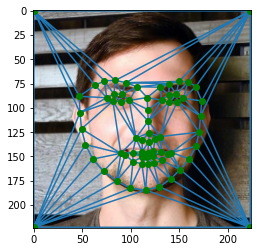

In [41]:
img_1 = plt.imread("ex_imgs/person1.jpg")
temp_im1, im1 = process_img(img_1)

images = torch.from_numpy(temp_im1)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()

outputs = model(images).float()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()
pts[:,0] *= 224
pts[:,1] *= 224
im1_pts = np.concatenate((pts, CORNERS), axis = 0)


plt.imshow(im1 + 0.5)
plt.triplot(im1_pts[:, 0], im1_pts[:, 1], Delaunay(im1_pts).simplices)
plt.plot(im1_pts[:,0], im1_pts[:,1], 'go')
plt.show()

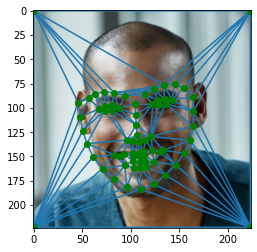

In [40]:
img_2 = plt.imread("ex_imgs/person2.jpg")
temp_im2, im2 = process_img(img_2)

images = torch.from_numpy(temp_im2)
images = torch.unsqueeze(torch.unsqueeze(images, 0), 0).float()

outputs = model(images).float()
pts = torch.reshape(outputs, shape = (68, 2)).detach().numpy()
pts[:,0] *= 224
pts[:,1] *= 224
im2_pts = np.concatenate((pts, CORNERS), axis = 0)


plt.imshow(im2 + 0.5, cmap = 'gray')
plt.triplot(im2_pts[:, 0], im2_pts[:, 1], Delaunay(im2_pts).simplices)
plt.plot(im2_pts[:,0], im2_pts[:,1], 'go')
plt.show()

In [12]:
multiprocessing.cpu_count()

8

In [35]:
# Parallized morph code using dask
results = []

for i in range(FRAMES):
  temp = dask.delayed(morph_parallel)(i, im2, im1, im2_pts, im1_pts)
  results.append(temp)

fframes = dask.compute(results)
exportname = "output_images/parallel_morph_person1_and_person2.gif"
imageio.mimsave(exportname, fframes[0], format='GIF', duration= 2.5/FRAMES)

In [ ]:
# Regular morph code

# out_frames = morph(im2, im1, im2_pts, im1_pts)
# exportname = "output_images/parallel_morph_curry_and_lebron.gif"
# imageio.mimsave(exportname, out_frames, format='GIF', duration= 2.5/FRAMES)